In [1]:
#Import of packages 
import pandas as pd
import math
import numpy as np
import random
import fractions
# setup plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import style

In [2]:
def find_neighbourhood(N,L,x):
    def left(N,L,x):
        i = x % N
        j = x // N
        return (i - 1 + N) % N + N * j
    def right(N,L,x):
        i = x % N
        j = x // N
        return (i + 1 + N) % N + N * j
    def up(N,L,x):
        i = x % N
        j = x // N
        return (i + N * (j+1) + N * L) % (N * L)
    def down(N,L,x):
        i = x % N
        j = x // N
        return (i + N * (j-1) + N * L) % (N * L)
    w1_out,w2_out,w3_out,w4_out = right(N,L,x), up(N,L,x), up(N,L,right(N,L,x)),down(N,L,right(N,L,x))
    return w1_out,w2_out,w3_out,w4_out

In [3]:
def up(N,L,x):
        i = x % N
        j = x // N
        return (i + N * (j-1) + N * L) % (N * L)
def left(N,L,x):
        i = x % N
        j = x // N
        return (i - 1 + N) % N + N * j
def B_and_G(N,L,w1,w2,w3,w_4):
    num_nodes = N * L
    num_edges = N * L * 4
    num_faces = N * L * 4
    B1 = np.zeros((num_nodes, num_edges))
    B2 = np.zeros((num_edges, num_faces))
    G1 = np.zeros((num_edges, num_edges))
    for x in range(num_nodes):
        w1_out,w2_out,w3_out,w4_out = find_neighbourhood(N,L,x)
        for j in range(4):
            edge = [w1_out,w2_out,w3_out,w4_out][j]
            B1[x, 4 * x + j] = -1
            B1[edge, 4 * x + j] = 1
            G1[4 * x + j,4 * x + j] = np.sqrt([w1,w2,w3,w_4][j])
        B2[4*x+1,4*x],B2[4*up(N,L,x),4*x],B2[4*x+2,4*x] = 1,1,-1
        B2[4*x,4*x+1],B2[4*left(N,L,x)+1,4*x+1],B2[4*x+2,4*x+1] = 1,1,-1
        B2[4*x+1,4*x+2],B2[4*x,4*x+2],B2[4*up(N,L,x)+3,4*x+2] = 1,-1,1
        B2[4*up(N,L,x),4*x+3],B2[4*left(N,L,x)+1,4*x+3],B2[4*up(N,L,x)+3,4*x+3] = -1,1,1
    return B1, B2, G1

In [4]:
def L1(N,L,w1,w2,w3,w4):
    B1, B2, G1 = B_and_G(N,L,w1,w2,w3,w4)
    Gm = np.linalg.inv(G1)
    L1up = Gm.dot(B2).dot(B2.transpose()).dot(Gm)
    L1down = G1.dot(B1.transpose()).dot(B1).dot(G1)
    return L1up, L1down
def W_3(w1,w2):
    return 1/(1/np.sqrt(w1) + 1/np.sqrt(w2))**2
def W_4(w1,w2):
    return 1/(1/np.sqrt(w1) - 1/np.sqrt(w2))**2

In [5]:
w1, w2 = 1, 4
w3 = W_3(w1,w2)
w4 = W_4(w1,w2)
L1up, L1down = L1(10,10,w1, w2, W_3(w1,w2), W_4(w1,w2))
Lk = - L1up - L1down
Nk = len(Lk[0])
Lambda_k, V_k = np.linalg.eig(Lk)

In [6]:
sigma = 1 + 4.3j
beta = 1 + 1.1j
mu = 1 - 0.5j
m = 3
z0 = np.sqrt(np.real(sigma)/np.real(beta))

In [7]:
#MSF
JF = np.matrix([[-2*np.real(sigma), 0],[-2*np.imag(beta)*np.real(sigma)/np.real(beta), 0]])
JH = np.matrix([[z0**(m-1)*m*np.real(mu), -z0**(m-1)*np.imag(mu)],[z0**(m-1)*m*np.imag(mu) ,z0**(m-1)*np.real(mu)]])
nk = Nk
X = np.linspace(np.real(min(Lambda_k)),0,nk)
Disp = []
Sim_disp = []
for i in range(nk):
    x = X[i]
    J = JF + x * JH
    Disp.append(np.real(max(np.linalg.eig(J)[0])))
    Sim_disp.append(np.real(max(np.linalg.eig(JF + Lambda_k[i] * JH)[0])))

/Users/runyuewang/opt/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


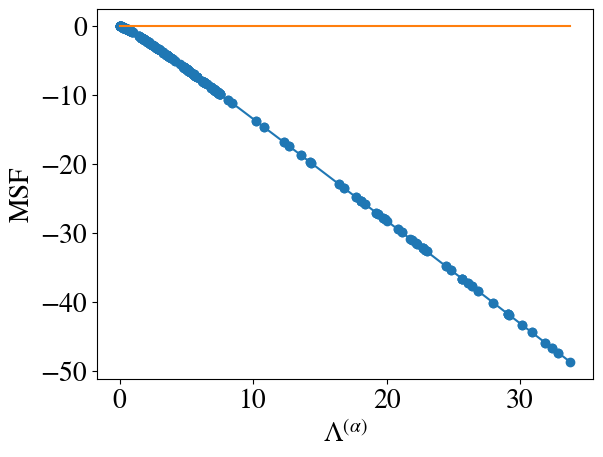

In [8]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.scatter(-Lambda_k, Sim_disp)
plt.plot(-X,Disp)
plt.plot(-X, np.zeros(nk))
plt.xlabel(r'$\Lambda^{(\alpha)}$')
plt.ylabel('MSF')
plt.show()

In [9]:
#Numerical Integration with RK4
h = 1/100
t_init = 0
t_final = 500
w0 = np.random.uniform(0,1,(Nk, 2)).view(np.complex128).reshape(Nk,)

In [10]:
def dw(sigma,w,beta,m,Lk,mu):
    return  sigma * w - (beta * w)*(np.abs(w) ** 2) + mu * Lk.dot(w*(np.abs(w)**(m-1)))
def Rk4(sigma,w,beta,m,Lk,mu, t_init, t_final, h):
    k1 = dw(sigma,w,beta,m,Lk,mu)
    k2 = dw(sigma,w + h * k1 / 2,beta,m,Lk,mu)
    k3 = dw(sigma,w + h * k2 / 2,beta,m,Lk,mu)
    k4 = dw(sigma,w + h * k3 ,beta, m,Lk,mu)
    delta = (h/6)*(k1 + 2 * k2 + 2 * k3 + k4)
    #print("warning", max(np.real(w + delta)), max(np.real(delta)))
    return w + delta
def Generate_Wt(sigma,w0,beta,m,Lk,mu, t_init, t_final, h):
    nt = int(t_final/h)
    ttime = np.linspace(t_init,t_final,nt)
    Wt = [w0]
    for i in range(nt):
        w = Rk4(sigma,Wt[i],beta,m,Lk,mu, t_init, t_final, h)
        Wt.append(w)
        #print (max(np.real(w)))
    return Wt[1:], ttime

In [11]:
Wt, ttime = Generate_Wt(sigma,w0,beta,m,Lk,mu, t_init, t_final, h)

In [12]:
len(Lk)

400

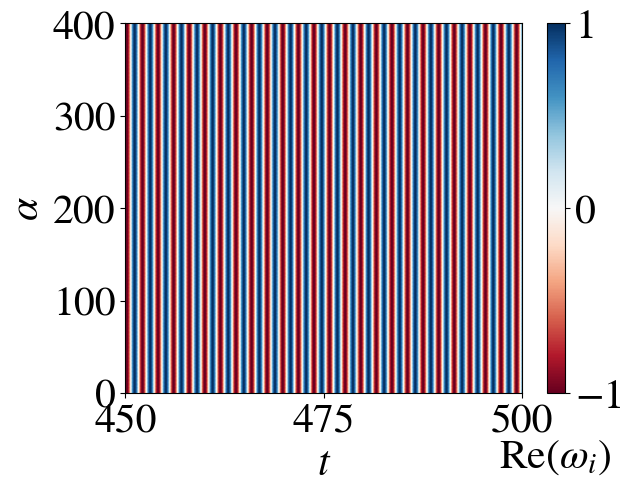

In [17]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.imshow(np.matrix(np.real(Wt[45000:])).transpose(),cmap=plt.cm.RdBu,extent=(450,500,0,len(Wt[0])),
           origin = "lower", interpolation='none',  aspect="auto")
plt.xticks([450,475,500])
plt.xlabel(r'$t$')
plt.ylabel(r'$\alpha$')
plt.colorbar().set_label(r'$\mathrm{Re}(\omega_i)$', labelpad=-50, y=-0.12, rotation=0)
plt.show()

In [19]:
#Order parameters
Rw = []
W = np.array(Wt)
for i in range(len(Wt)):
    Rw.append(abs(sum(W[i]))/Nk)

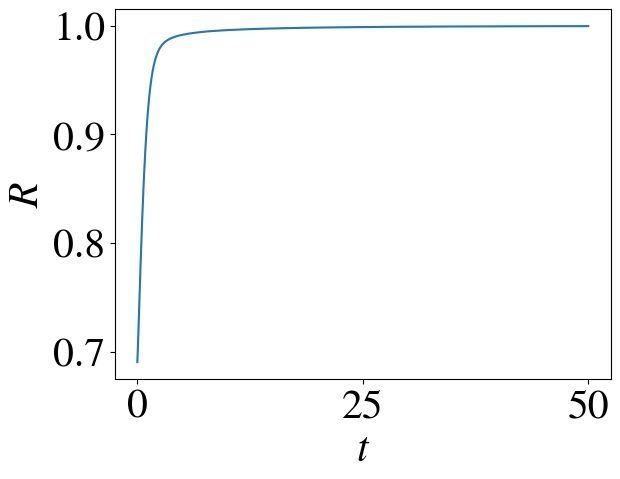

In [21]:
plt.rcParams.update({'font.size': 30})
plt.plot(ttime[:5000], Rw[:5000])
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.xticks([0,25,50])
plt.xlabel(r'$t$')
plt.ylabel(r'$R$')
plt.show()

# Torus

In [22]:
def find_neighbourhood(N,L,x):
    def left(N,L,x):
        i = x % N
        j = x // N
        return (i - 1 + N) % N + N * j
    def right(N,L,x):
        i = x % N
        j = x // N
        return (i + 1 + N) % N + N * j
    def up(N,L,x):
        i = x % N
        j = x // N
        return (i + N * (j+1) + N * L) % (N * L)
    def down(N,L,x):
        i = x % N
        j = x // N
        return (i + N * (j-1) + N * L) % (N * L)
    w1_out,w2_out,w3_out = right(N,L,x), up(N,L,x), up(N,L,right(N,L,x))
    return w1_out,w2_out,w3_out

In [23]:
def B_and_G(N,L,w1,w2,w3):
    num_nodes = N * L
    num_edges = N * L * 3
    num_faces = N * L * 2
    B1 = np.zeros((num_nodes, num_edges))
    B2 = np.zeros((num_edges, num_faces))
    G1 = np.zeros((num_edges, num_edges))
    for x in range(num_nodes):
        w1_out,w2_out,w3_out = find_neighbourhood(N,L,x)
        for j in range(3):
            edge = [w1_out,w2_out,w3_out][j]
            B1[x, 3*x + j] = -1
            B1[edge, 3*x + j] = 1
            G1[3*x + j,3*x + j] = np.sqrt([w1,w2,w3][j])
        B2[1+3*x,2*x], B2[(3 * N +3*x)%num_edges,2*x], B2[3*x,2*x+1], B2[(4+3*x)%(3*N) + 3 * (N * (x // N)),2*x+1] = 1,1,1,1
        B2[2+3*x,2*x],B2[2+3*x,2*x+1] = -1, -1
    return B1, B2, G1

In [24]:
def L1(N,L,w1,w2,w3):
    B1, B2, G1 = B_and_G(N,L,w1,w2,w3)
    Gm = np.linalg.inv(G1)
    L1up = Gm.dot(B2).dot(B2.transpose()).dot(Gm)
    L1down = G1.dot(B1.transpose()).dot(B1).dot(G1)
    return L1up, L1down

In [25]:
w1, w2 = 1, 4
L1up, L1down = L1(10,10,w1, w2, W_3(w1,w2))
Lk = - L1up - L1down
Nk = len(Lk[0])
Lambda_k, V_k = np.linalg.eig(Lk)
sigma = 1 + 4.3j
beta = 1 + 1.1j
mu = 1 - 0.5j
m = 3
z0 = np.sqrt(np.real(sigma)/np.real(beta))

In [26]:
#MSF
JF = np.matrix([[-2*np.real(sigma), 0],[-2*np.imag(beta)*np.real(sigma)/np.real(beta), 0]])
JH = np.matrix([[z0**(m-1)*m*np.real(mu), -z0**(m-1)*np.imag(mu)],[z0**(m-1)*m*np.imag(mu) ,z0**(m-1)*np.real(mu)]])
nk = Nk
X = np.linspace(np.real(min(Lambda_k)),0,nk)
Disp = []
Sim_disp = []
for i in range(nk):
    x = X[i]
    J = JF + x * JH
    Disp.append(np.real(max(np.linalg.eig(J)[0])))
    Sim_disp.append(np.real(max(np.linalg.eig(JF + Lambda_k[i] * JH)[0])))

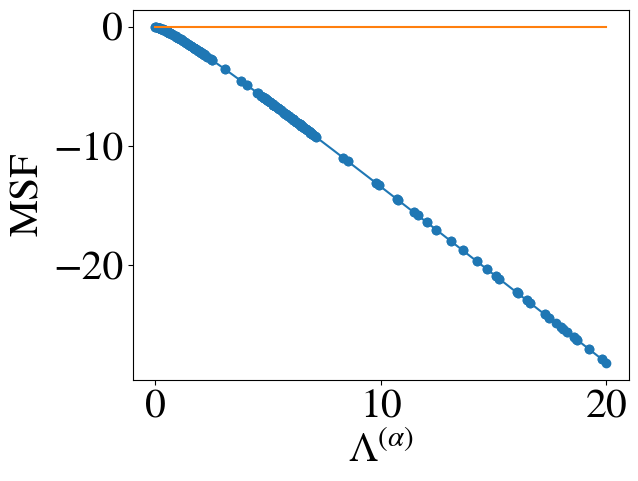

In [27]:
plt.scatter(-Lambda_k, Sim_disp)
plt.plot(-X,Disp)
plt.plot(-X, np.zeros(nk))
plt.xlabel(r'$\Lambda^{(\alpha)}$')
plt.ylabel('MSF')
plt.show()

In [28]:
#Numerical Integration with RK4
h = 1/100
t_init = 0
t_final = 500
w0 = np.random.uniform(0,1,(Nk, 2)).view(np.complex128).reshape(Nk,)
Wt, ttime = Generate_Wt(sigma,w0,beta,m,Lk,mu, t_init, t_final, h)

In [29]:
Lk.shape

(300, 300)

In [30]:
len(Wt)

50000

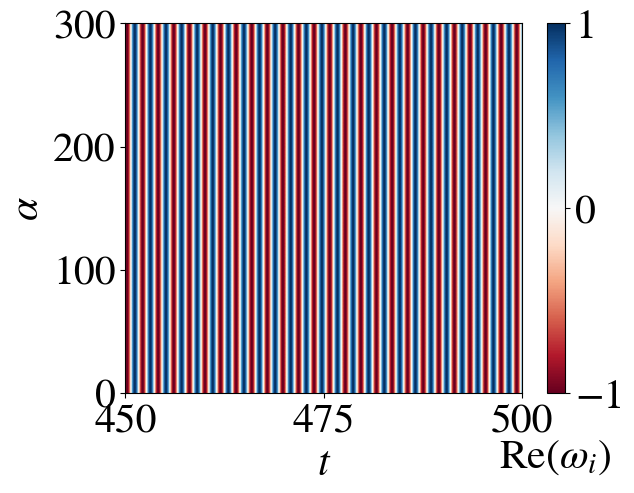

In [35]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.imshow(np.matrix(np.real(Wt[45000:])).transpose(),cmap=plt.cm.RdBu,extent=(450,500,0,len(Wt[0])),
           origin = "lower", interpolation='none',  aspect="auto")
plt.xticks([450,475,500])
plt.xlabel(r'$t$')
plt.ylabel(r'$\alpha$')
plt.colorbar().set_label(r'$\mathrm{Re}(\omega_i)$', labelpad=-50, y=-0.12, rotation=0)
plt.show()

In [32]:
#Order parameters
Rw = []
W = np.array(Wt)
for i in range(len(Wt)):
    Rw.append(abs(sum(W[i]))/Nk)

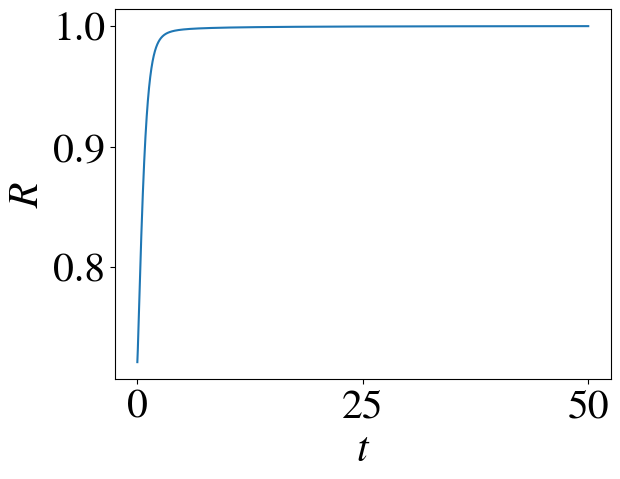

In [33]:
plt.plot(ttime[:5000],Rw[:5000])
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.xticks([0,25,50])
plt.xlabel(r'$t$')
plt.ylabel(r'$R$')
plt.show()

In [34]:
#Triangulated torus

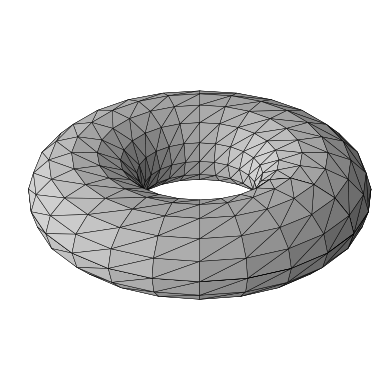

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def torus_points(num_circles, num_points_per_circle, major_radius, minor_radius):
    theta = np.linspace(0, 2*np.pi, num_points_per_circle)
    phi = np.linspace(0, 2*np.pi, num_circles)
    theta, phi = np.meshgrid(theta, phi)
    x = (major_radius + minor_radius * np.cos(theta)) * np.cos(phi)
    y = (major_radius + minor_radius * np.cos(theta)) * np.sin(phi)
    z = minor_radius * np.sin(theta)
    return x, y, z

def diagonal_meshed_torus(num_circles, num_points_per_circle, major_radius, minor_radius):
    x, y, z = torus_points(num_circles, num_points_per_circle, major_radius, minor_radius)
    vertices = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    faces = []
    for i in range(num_circles):
        for j in range(num_points_per_circle):
            p0 = i * num_points_per_circle + j
            p1 = ((i + 1) % num_circles) * num_points_per_circle + j
            p2 = ((i + 1) % num_circles) * num_points_per_circle + (j + 1) % num_points_per_circle
            p3 = i * num_points_per_circle + (j + 1) % num_points_per_circle
            faces.append([p0, p1, p2])
            faces.append([p0, p2, p3])
    return vertices, np.array(faces)

num_circles = 25
num_points_per_circle = 15
major_radius = 2
minor_radius = 1

vertices, faces = diagonal_meshed_torus(num_circles, num_points_per_circle, major_radius, minor_radius)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces,
                         linewidth = 0.3, 
                         antialiased = True,
                         edgecolor = 'black', color= 'lightgrey', alpha = 1)

plt.axis('off')
plt.show()